In [1]:
# General imports
import numpy as np
import torch
import matplotlib.pylab as plt

# DeepMoD functions

from deepymod import DeepMoD
from deepymod.model.func_approx import NN
from deepymod.model.library import Library2D_third
from deepymod.model.constraint import LeastSquares
from deepymod.model.sparse_estimators import Threshold,PDEFIND
from deepymod.training import train
from deepymod.training.sparsity_scheduler import TrainTestPeriodic
from scipy.io import loadmat

# Settings for reproducibility
np.random.seed(1)
torch.manual_seed(1)

device = 'cpu'

%load_ext autoreload
%autoreload 2

In [63]:
from sklearn.linear_model import LassoCV
from derivatives import finite_diff

In [64]:
data = loadmat('Diffusion_2D_space81.mat')
data = np.real(data['Expression1']).reshape((81,81,81,4))[:,:,:,3]
x_dim, y_dim, t_dim = data.shape

## No noise

In [166]:
time_range = [1,2,4,6,8,10,12,14,20]
#time_range = [20,14,12,10,8,6,4,2,1]
x_range = [10,8,5,4,3,2,1] 
#x_range = [1,2,3,4,5,8,10]

In [167]:
mask = np.array([False,False,True,True,True,False])
ref = np.array([0,0,0.2,0.02,0.02,0]) 
ref_b =  np.array([0,0,0.2,0.02,0.02,0]) + 10**-9*np.ones(6)

In [168]:
error = []
bor = 1
for idt in time_range:
    
    for idx in x_range:
        
        # Prepare data
        down_data= np.take(np.take(np.take(data,np.arange(0,x_dim,idx),axis=0),np.arange(0,y_dim,idx),axis=1),np.arange(0,t_dim,idt),axis=2)
        print("Dowmsampled shape:",down_data.shape)
        width, width_2, steps = down_data.shape
        x_arr, y_arr, t_arr = np.linspace(0,1,width), np.linspace(0,1,width_2), np.linspace(0,1,steps)
        x_grid, y_grid, t_grid = np.meshgrid(x_arr, y_arr, t_arr, indexing='ij')
        X = np.transpose((t_grid.flatten(), x_grid.flatten(), y_grid.flatten()))
        y = down_data.reshape((down_data.size, 1))

        # Add noise to the solution 
        noise_level = 0.0
        y_noisy = y + noise_level * np.std(y) * np.random.randn(y.size, 1)
        solution = y_noisy.reshape(down_data.shape)
        denoised_sol = solution
           
        # Construct the library
        u = denoised_sol[:,:,:][bor:-bor,bor:-bor,:]
        u_t = finite_diff(denoised_sol[:,:,:],t_arr,order=1,axis=2)[bor:-bor,bor:-bor,:].reshape((-1, 1))
        u_x = finite_diff(denoised_sol[:,:,:],x_arr,order=1,axis=0)[bor:-bor,bor:-bor,:]
        u_xx = finite_diff(denoised_sol[:,:,:],x_arr,order=2,axis=0)[bor:-bor,bor:-bor,:]
        u_y = finite_diff(denoised_sol[:,:,:],y_arr,order=1,axis=1)[bor:-bor,bor:-bor,:]
        u_yy = finite_diff(denoised_sol[:,:,:],y_arr,order=2,axis=1)[bor:-bor,bor:-bor,:]
        u_xy = finite_diff(finite_diff(denoised_sol[:,:,:],x_arr,order=1,axis=0),y_arr,order=1,axis=1)[bor:-bor,bor:-bor,:]

        library = np.transpose((np.ones_like(u).flatten(), u_x.flatten(), u_y.flatten(),
                          u_xx.flatten(),u_yy.flatten(),u_xy.flatten()))

        reg = LassoCV(fit_intercept=False, cv=10)
        xi = reg.fit(library, u_t).coef_[:, None].flatten()
        if np.ma.allequal(xi.astype(bool), mask) == True:
            print('correct')
            k = np.sum(np.abs((xi-ref)/ref_b))
            if k > 4: 
                error.append(4) 
            else:
                error.append(np.sum(np.abs((xi-ref)/ref_b)))
        else: 
            error.append(4); 
            print('wrong')

Dowmsampled shape: (9, 9, 81)
correct
Dowmsampled shape: (11, 11, 81)
correct
Dowmsampled shape: (17, 17, 81)
correct
Dowmsampled shape: (21, 21, 81)
correct
Dowmsampled shape: (27, 27, 81)
correct
Dowmsampled shape: (41, 41, 81)
correct
Dowmsampled shape: (81, 81, 81)
correct
Dowmsampled shape: (9, 9, 41)
correct
Dowmsampled shape: (11, 11, 41)
correct
Dowmsampled shape: (17, 17, 41)
correct
Dowmsampled shape: (21, 21, 41)
correct
Dowmsampled shape: (27, 27, 41)
correct
Dowmsampled shape: (41, 41, 41)
correct
Dowmsampled shape: (81, 81, 41)
correct
Dowmsampled shape: (9, 9, 21)
wrong
Dowmsampled shape: (11, 11, 21)
correct
Dowmsampled shape: (17, 17, 21)
correct
Dowmsampled shape: (21, 21, 21)
correct
Dowmsampled shape: (27, 27, 21)
correct
Dowmsampled shape: (41, 41, 21)
correct
Dowmsampled shape: (81, 81, 21)
correct
Dowmsampled shape: (9, 9, 14)
wrong
Dowmsampled shape: (11, 11, 14)
correct
Dowmsampled shape: (17, 17, 14)
correct
Dowmsampled shape: (21, 21, 14)
correct
Dowmsampled 

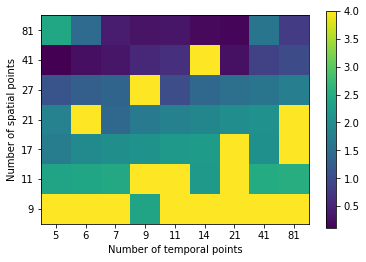

In [169]:
data_loop = [5,6,7,9,11,14,21,41,81]
plt.imshow(np.array(error).reshape(7,-1))
plt.yticks([0,1,2,3,4,5,6],['81', '41', '27', '21','17','11','9'])
plt.xticks([0,1,2,3,4,5,6,7,8],data_loop)
plt.xlabel('Number of temporal points')
plt.ylabel('Number of spatial points')
plt.colorbar()
plt.show()

## No noise

In [91]:
time_range = [1,2,4,6,8,10,12,14,20]
x_range = [8,5,4,3,2,1] 

In [92]:
mask = np.array([False,False,True,True,True,False])
ref = np.array([0,0,0.2,0.02,0.02,0]) 
ref_b =  np.array([0,0,0.2,0.02,0.02,0]) + 10**-9*np.ones(6)

In [99]:
error = []
bor = 1
for idt in time_range:
    
    for idx in x_range:
        
        # Prepare data
        down_data= np.take(np.take(np.take(data,np.arange(0,x_dim,idx),axis=0),np.arange(0,y_dim,idx),axis=1),np.arange(0,t_dim,idt),axis=2)
        print("Dowmsampled shape:",down_data.shape)
        width, width_2, steps = down_data.shape
        x_arr, y_arr, t_arr = np.linspace(0,1,width), np.linspace(0,1,width_2), np.linspace(0,1,steps)
        x_grid, y_grid, t_grid = np.meshgrid(x_arr, y_arr, t_arr, indexing='ij')
        X = np.transpose((t_grid.flatten(), x_grid.flatten(), y_grid.flatten()))
        y = down_data.reshape((down_data.size, 1))

        # Add noise to the solution 
        noise_level = 0.10
        y_noisy = y + noise_level * np.std(y) * np.random.randn(y.size, 1)
        solution = y_noisy.reshape(down_data.shape)
        # Use SVD to denoise the solution 
        dim_w = 3
        denoised_sol = []
        for i in np.arange(steps):
            uwn,sigmawn,vwn= np.linalg.svd(solution[:,:,i])
            vwn = vwn.T
            denoised_sol.append(uwn[:,0:dim_w].dot(np.diag(sigmawn[0:dim_w]).dot(vwn[:,0:dim_w].T)))
        denoised_sol = np.transpose(np.array(denoised_sol),(1,2,0))
           
        # Construct the library
        u = denoised_sol[:,:,:][bor:-bor,bor:-bor,:]
        u_t = finite_diff(denoised_sol[:,:,:],t_arr,order=1,axis=2)[bor:-bor,bor:-bor,:].reshape((-1, 1))
        u_x = finite_diff(denoised_sol[:,:,:],x_arr,order=1,axis=0)[bor:-bor,bor:-bor,:]
        u_xx = finite_diff(denoised_sol[:,:,:],x_arr,order=2,axis=0)[bor:-bor,bor:-bor,:]
        u_y = finite_diff(denoised_sol[:,:,:],y_arr,order=1,axis=1)[bor:-bor,bor:-bor,:]
        u_yy = finite_diff(denoised_sol[:,:,:],y_arr,order=2,axis=1)[bor:-bor,bor:-bor,:]
        u_xy = finite_diff(finite_diff(denoised_sol[:,:,:],x_arr,order=1,axis=0),y_arr,order=1,axis=1)[bor:-bor,bor:-bor,:]

        library = np.transpose((np.ones_like(u).flatten(), u_x.flatten(), u_y.flatten(),
                          u_xx.flatten(),u_yy.flatten(),u_xy.flatten()))

        reg = LassoCV(fit_intercept=False, cv=10)
        xi = reg.fit(library, u_t).coef_[:, None].flatten()
        if np.ma.allequal(xi.astype(bool), mask) == True:
            print('correct')
            k = np.sum(np.abs((xi-ref)/ref_b))
            if k > 2: 
                error.append(2) 
            else:
                error.append(np.sum(np.abs((xi-ref)/ref_b)))
        else: 
            error.append(2); 
            print('wrong')

Dowmsampled shape: (11, 11, 81)
correct
Dowmsampled shape: (17, 17, 81)
wrong
Dowmsampled shape: (21, 21, 81)
correct
Dowmsampled shape: (27, 27, 81)
correct
Dowmsampled shape: (41, 41, 81)
correct
Dowmsampled shape: (81, 81, 81)
wrong
Dowmsampled shape: (11, 11, 41)
wrong
Dowmsampled shape: (17, 17, 41)
correct
Dowmsampled shape: (21, 21, 41)
correct
Dowmsampled shape: (27, 27, 41)
correct
Dowmsampled shape: (41, 41, 41)
correct
Dowmsampled shape: (81, 81, 41)
wrong
Dowmsampled shape: (11, 11, 21)
correct
Dowmsampled shape: (17, 17, 21)
correct
Dowmsampled shape: (21, 21, 21)
correct
Dowmsampled shape: (27, 27, 21)
correct
Dowmsampled shape: (41, 41, 21)
correct
Dowmsampled shape: (81, 81, 21)
wrong
Dowmsampled shape: (11, 11, 14)
correct
Dowmsampled shape: (17, 17, 14)
correct
Dowmsampled shape: (21, 21, 14)
correct
Dowmsampled shape: (27, 27, 14)
correct
Dowmsampled shape: (41, 41, 14)
correct
Dowmsampled shape: (81, 81, 14)
wrong
Dowmsampled shape: (11, 11, 11)
wrong
Dowmsampled sh

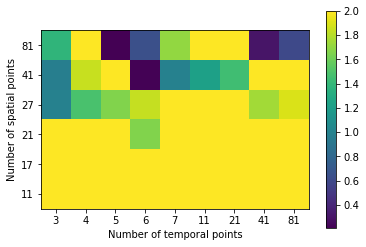

In [100]:
data_loop = [3,4,5,6,7,11,21,41,81]
plt.imshow(np.array(error).reshape(6,-1))
plt.yticks([0,1,2,3,4,5],['81', '41', '27', '21','17','11'])
plt.xticks([0,1,2,3,4,5,6,7,8],data_loop)
plt.xlabel('Number of temporal points')
plt.ylabel('Number of spatial points')
plt.colorbar()
plt.show()

In [17]:
     # Use SVD to denoise the solution 
        dim_w = 3
        denoised_sol = []
        for i in np.arange(steps):
            uwn,sigmawn,vwn= np.linalg.svd(solution[:,:,i])
            vwn = vwn.T
            denoised_sol.append(uwn[:,0:dim_w].dot(np.diag(sigmawn[0:dim_w]).dot(vwn[:,0:dim_w].T)))
        denoised_sol = np.transpose(np.array(denoised_sol),(1,2,0))


array([[False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [False]])

Select the number of samples:

In [189]:
# Prepare data
idx= 1
down_data= np.take(np.take(np.take(data,np.arange(0,x_dim,x_range),axis=0),np.arange(0,y_dim,y_range),axis=1),np.arange(0,t_dim,idx),axis=2)
print("Dowmsampled shape:",down_data.shape)
width, width_2, steps = down_data.shape
x_grid, y_grid, t_grid = np.meshgrid(np.linspace(0,1,width), np.linspace(0,1,width_2), np.linspace(0,1,steps), indexing='ij')
X = np.transpose((t_grid.flatten(), x_grid.flatten(), y_grid.flatten()))
y = down_data.reshape((down_data.size, 1))

# Add noise to the solution 
noise_level = 0.0
y_noisy = y + noise_level * np.std(y) * np.random.randn(y.size, 1)
solution = y_noisy.reshape(down_data.shape)

# Use SVD to denoise the solution 
dim_w = 3
denoised_sol = []
for i in np.arange(steps):
    uwn,sigmawn,vwn= np.linalg.svd(solution[:,:,i])
    vwn = vwn.T
    denoised_sol.append(uwn[:,0:dim_w].dot(np.diag(sigmawn[0:dim_w]).dot(vwn[:,0:dim_w].T)))
# denoised_sol = np.transpose(np.array(denoised_sol),(1,2,0))
denoised_sol = solution
# Construct the library
u = denoised_sol[:,:,:]
u_t = finite_diff(denoised_sol[:,:,:],t_arr,order=1,axis=2).reshape((-1, 1))
u_x = finite_diff(denoised_sol[:,:,:],x_arr,order=1,axis=0)
u_xx = finite_diff(denoised_sol[:,:,:],x_arr,order=2,axis=0)
u_y = finite_diff(denoised_sol[:,:,:],y_arr,order=1,axis=1)
u_yy = finite_diff(denoised_sol[:,:,:],y_arr,order=2,axis=1)
u_xy = finite_diff(finite_diff(denoised_sol[:,:,:],x_arr,order=1,axis=0),y_arr,order=1,axis=1)
#u_xxx = finite_diff(denoised_sol[:,:,:],y_arr,order=3,axis=0)
#u_yyy = finite_diff(denoised_sol[:,:,:],y_arr,order=3,axis=1)
#u_xxy = finite_diff(finite_diff(denoised_sol[:,:,:],x_arr,order=2,axis=0),y_arr,order=1,axis=1)

library = np.transpose((np.ones_like(u).flatten(),u.flatten(), u_x.flatten(), u_y.flatten(),
                  u_xx.flatten(),u_yy.flatten(),u_xy.flatten()))

Dowmsampled shape: (41, 41, 41)


<ipython-input-189-a076f6786be1>:39: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  np.linalg.lstsq(library, u_t)[0]


array([[ 5.97222952e-04],
       [-3.96337703e-02],
       [ 1.42742806e-12],
       [ 8.09012108e-03],
       [ 7.55162987e-04],
       [ 7.52493450e-04],
       [-5.54163127e-13]])

In [202]:
np.linalg.lstsq(library, u_t)[0][4]*2

<ipython-input-202-349383d00c98>:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  np.linalg.lstsq(library, u_t)[0][4]*2


array([0.00151033])

In [203]:
np.linalg.lstsq(library, u_t)[0][5]*40

<ipython-input-203-55a136c605bb>:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  np.linalg.lstsq(library, u_t)[0][5]*40


array([0.03009974])

In [183]:
steps = down_data.shape[2]
dim_w = 2
denoised_sol = []
for i in np.arange(steps):
    uwn,sigmawn,vwn= np.linalg.svd(solution[:,:,i])
    vwn = vwn.T
    denoised_sol.append(uwn[:,0:dim_w].dot(np.diag(sigmawn[0:dim_w]).dot(vwn[:,0:dim_w].T)))
denoised_sol = np.transpose(np.array(denoised_sol),(1,2,0))

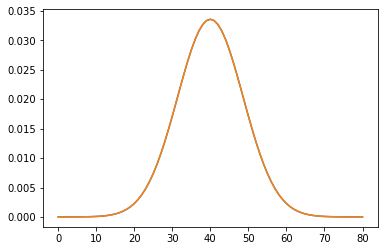

In [184]:
plt.plot(denoised_sol[:,20,1])
plt.plot(solution[:,20,1])

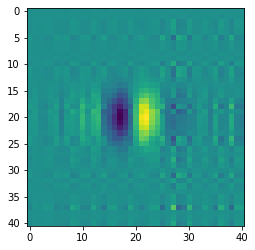

In [148]:
plt.imshow(finite_diff(denoised_sol[:,:,:],x_arr,order=3,axis=1)[:,:,3])

In [137]:
bor = 2

u = denoised_sol[:,:,:][bor:-bor,bor:-bor,:]
u_t = finite_diff(denoised_sol[:,:,:],t_arr,order=1,axis=2)[bor:-bor,bor:-bor,:]
u_x = finite_diff(denoised_sol[:,:,:],x_arr,order=1,axis=0)[bor:-bor,bor:-bor,:]
u_xx = finite_diff(denoised_sol[:,:,:],x_arr,order=2,axis=0)[bor:-bor,bor:-bor,:]
u_y = finite_diff(denoised_sol[:,:,:],y_arr,order=1,axis=1)[bor:-bor,bor:-bor,:]
u_yy = finite_diff(denoised_sol[:,:,:],y_arr,order=2,axis=1)[bor:-bor,bor:-bor,:]
u_xy = finite_diff(finite_diff(denoised_sol[:,:,:],x_arr,order=1,axis=0),y_arr,order=1,axis=1)[bor:-bor,bor:-bor,:]
u_xxx = finite_diff(denoised_sol[:,:,:],y_arr,order=3,axis=0)[bor:-bor,bor:-bor,:]
u_yyy = finite_diff(denoised_sol[:,:,:],y_arr,order=3,axis=1)[bor:-bor,bor:-bor,:]
u_xxy = finite_diff(finite_diff(denoised_sol[:,:,:],x_arr,order=2,axis=0),y_arr,order=1,axis=1)[bor:-bor,bor:-bor,:]

In [138]:
X = np.transpose((t_grid[bor:-bor,bor:-bor,:].flatten(), x_grid[bor:-bor,bor:-bor,:].flatten(), y_grid[bor:-bor,bor:-bor,:].flatten()))
library = np.float32((np.ones_like(u).flatten(),u.flatten(), u_x.flatten(), u_y.flatten(),
                      u_xx.flatten(),u_yy.flatten(),u_xy.flatten(),
                      u_xxx.flatten(),u_yyy.flatten(),u_xxy.flatten())).T
u_t = u_t.reshape((-1, 1))

In [139]:
reg = LassoCV(fit_intercept=False, cv=10)
print(reg.fit(library, u_t).coef_[:, None])# %%

[[-0.0000000e+00]
 [-0.0000000e+00]
 [ 0.0000000e+00]
 [ 1.0230744e-01]
 [ 1.6869776e-02]
 [ 1.6851673e-02]
 [ 0.0000000e+00]
 [ 0.0000000e+00]
 [-5.0987255e-05]
 [-2.5510968e-05]]


In [135]:
np.linalg.lstsq(library, u_t)[0]

<ipython-input-135-457ca3085e09>:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  np.linalg.lstsq(library, u_t)[0]


array([[ 1.44199594e-02],
       [-8.20801203e-01],
       [ 2.22328458e-10],
       [ 1.94433856e-01],
       [ 1.50354882e-02],
       [ 1.50357903e-02],
       [ 7.63485383e-12],
       [-3.85675636e-13],
       [ 7.66515948e-05],
       [ 8.56635335e-05]])

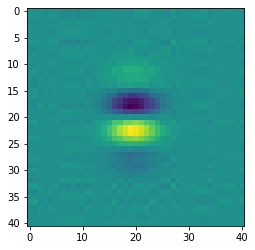

In [199]:
plt.imshow(finite_diff(denoised_sol[:,:,3],x_arr,order=3,axis=0))

In [48]:
y_arr.shape

(41,)

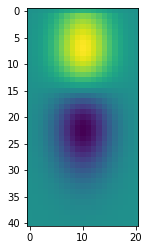

In [57]:
plt.imshow(finite_diff(down_data[:,:,3].T,y_arr,order=1))

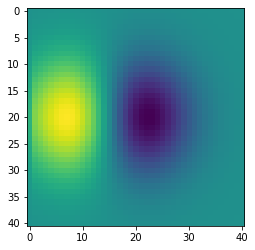

In [32]:
plt.imshow(finite_diff(down_data[:,:,3].T,y_arr,order=1).T)

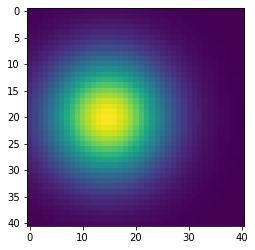

In [20]:
plt.imshow(down_data[:,:,3])

In [ ]:
def spline_diff2D(z, x, y, order, **spline_kwargs):
    ''' Fits 2D spline to 2D data. x and y are 1D arrays of coordinate grid, z is 2D array with dara.
    Good defaults for spline would be kx=4, ky=4, s=1e-2 with noise, 0.0 if no noise.'''
    spline = RectBivariateSpline(x, y, z, **spline_kwargs)
    return spline(x, y, dx=order, dy=order)
# Example usage
u_approx_spline = spline_diff2D(u_true, t, x, order=0, kx=4, ky=4, s=0.0) # approximation of data
u_approx_spline = spline_diff2D(u_true, t, x, order=3, kx=4, ky=4, s=0.0) # 3rd order deriv

In [ ]:

# %% Checking finite diff
dt, theta = library(u_true, x, t, deriv_kind='fd')
print(np.linalg.lstsq(theta, dt)[0]) # normal lst sq.
print(np.linalg.lstsq(theta.reshape(50, 100, 12)[2:-2, 3:-3, :].reshape(-1, 12), dt.reshape(50, 100)[2:-2, 3:-3].reshape(-1, 1))[0]) # lst sq. with edges cut off

reg = LassoCV(fit_intercept=False, cv=10)
print(reg.fit(theta, dt).coef_[:, None])# %%
print(reg.fit(theta.reshape(50, 100, 12)[2:-2, 3:-3, :].reshape(-1, 12), dt.reshape(50, 100)[2:-2, 3:-3].reshape(-1, 1)).coef_[:, None])# %%

# %% Checking spline 
dt, theta = library(u_true, x, t, deriv_kind='spline', s=0.0, k=5) #s=0.0 is necessary for decent spline fit
print(np.linalg.lstsq(theta, dt)[0]) # normal lst sq.
print(np.linalg.lstsq(theta.reshape(50, 100, 12)[2:-2, 3:-3, :].reshape(-1, 12), dt.reshape(50, 100)[2:-2, 3:-3].reshape(-1, 1))[0]) # lst sq. with edges cut off

reg = LassoCV(fit_intercept=False, cv=10)
print(reg.fit(theta, dt).coef_[:, None])# %%
print(reg.fit(theta.reshape(50, 100, 12)[2:-2, 3:-3, :].reshape(-1, 12), dt.reshape(50, 100)[2:-2, 3:-3].reshape(-1, 1)).coef_[:, None])# %%